In [14]:
import pandas as pd
import numpy as np


In [31]:
file_path3= "C:/Users/vgarciario/desktop/UA MASTER/labo3/productos_a_predecir.txt"
productos_predecir = pd.read_csv(file_path3, sep='\t')

file_path = 'C:/Users/vgarciario/desktop/UA MASTER/labo3/sell-in.txt'
sell_in = pd.read_csv(file_path, sep='\t')

file_path2 = 'C:/Users/vgarciario/desktop/UA MASTER/labo3/tb_productos_NUEVO.txt'
tb_productos_NUEVO = pd.read_csv(file_path2, sep='\t')

In [32]:
# Definir los periodos de interés
#periodos = [201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912]
periodos = [201701,201702,201703,201704,201705,201706,201707,201708,201709,201710,201711,201712,201801,201802,201803,201804,201805,201806,201807,201808,201809,201810,201811,201812,201901,201902,201903,201904,201905,201906,201907,201908,201909,201910,201911,201912]
# Filtrar las filas correspondientes a los periodos de interés
dataset = sell_in[sell_in['periodo'].isin(periodos)]

In [35]:
dataset = pd.merge(productos_predecir, sell_in, on='product_id', how='inner')
# dataset=pd.merge(dataset, tb_productos_NUEVO, on='product_id', how='inner')
dataset = dataset.groupby(['periodo', 'product_id', 'customer_id'])['tn'].sum().reset_index()

In [36]:
dataset.head

<bound method NDFrame.head of          periodo  product_id  customer_id         tn
0         201701       20001        10001   99.43861
1         201701       20001        10002   35.72806
2         201701       20001        10003  143.49426
3         201701       20001        10004  184.72927
4         201701       20001        10005   19.08407
...          ...         ...          ...        ...
2293476   201912       21267        10219    0.00131
2293477   201912       21276        10029    0.00075
2293478   201912       21276        10052    0.00594
2293479   201912       21276        10219    0.00075
2293480   201912       21276        10289    0.00148

[2293481 rows x 4 columns]>

In [38]:
dataset.to_csv("C:/Users/vgarciario/desktop/UA MASTER/labo3/dataset.csv", index=False)

In [10]:
dataset.columns

Index(['product_id', 'periodo', 'customer_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size'],
      dtype='object')

In [ ]:
pip install seaborn

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
import matplotlib.pyplot as plt

# Supongamos que ya tienes el DataFrame 'dataset' con las variables mencionadas
print("Columnas del dataset:", dataset.columns)

# Convertir 'periodo' a datetime
dataset['periodo'] = pd.to_datetime(dataset['periodo'], errors='coerce')

# Calcular el volumen total de compras por cliente
customer_purchases = dataset.groupby('customer_id')['tn'].sum().reset_index()

# Clasificar clientes en grupos según percentiles del volumen total de compras
customer_purchases['group'] = pd.qcut(customer_purchases['tn'], q=3, labels=['small', 'medium', 'large'])

# Unir los grupos de clientes al dataset original
dataset = dataset.merge(customer_purchases[['customer_id', 'group']], on='customer_id')

# Función para realizar clustering en un grupo de clientes
def cluster_customers_group(data, group_label, k_range=range(1, 11)):
    group_data = data[data['group'] == group_label]
    
    # Crear un DataFrame pivotante con NaNs para valores faltantes
    tn_data = group_data.pivot_table(index='periodo', columns=['product_id', 'customer_id'], values='tn')

    # Imputar valores faltantes usando la estrategia seleccionada 
    tn_data_filled = tn_data.fillna(0)
        
    # Eliminar columnas con todos valores NaN
    tn_data_filled = tn_data_filled.dropna(axis=1, how='all')

    # Verificar si después de la imputación todavía quedan NaNs y eliminarlos
    tn_data_filled = tn_data_filled.dropna(axis=1)

    # Verificar si hay series vacías
    if tn_data_filled.shape[1] == 0:
        print(f"El grupo {group_label} tiene todas las series vacías después de la imputación.")
        return pd.DataFrame()  # Retornar un DataFrame vacío si todas las series están vacías

    # Normalizar los datos
    scaler = MinMaxScaler()
    tn_data_normalizada = scaler.fit_transform(tn_data_filled)

    # Transponer los datos para que estén en el formato (n_samples, n_timestamps)
    tn_data_normalizada = tn_data_normalizada.T

    # Determinar el número óptimo de clusters utilizando el método del codo
    sse = []
    
    for k in k_range:
        kmeans = TimeSeriesKMeans(n_clusters=k, metric="dtw", random_state=0)
        kmeans.fit(tn_data_normalizada)
        sse.append(kmeans.inertia_)
    
    # Graficar el método del codo
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, sse, marker='o')
    plt.xlabel('Número de clusters')
    plt.ylabel('SSE')
    plt.title(f'Método del codo para grupo {group_label}')
    plt.show()
    
    
       # Seleccionar el número óptimo de clusters (ejemplo usando 3 clusters)
    optimal_k = 10
    kmeans = TimeSeriesKMeans(n_clusters=optimal_k, metric="dtw", random_state=0)
    labels = kmeans.fit_predict(tn_data_normalizada)
    
    # Crear un DataFrame con los resultados
    clusters = pd.DataFrame({
        'product_id': [x[0] for x in tn_data_filled.columns],
        'customer_id': [x[1] for x in tn_data_filled.columns],
        'cluster': labels
    })
    
    return clusters



Columnas del dataset: Index(['product_id', 'periodo', 'customer_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size'],
      dtype='object')


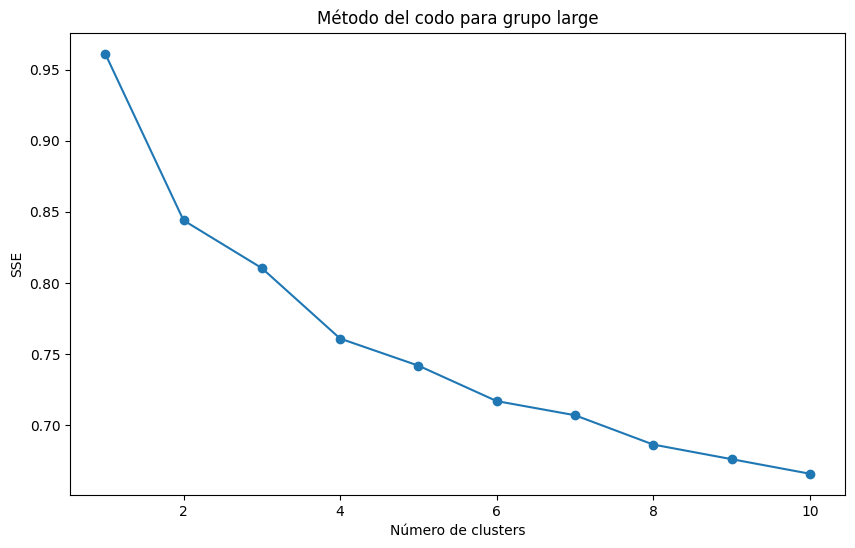

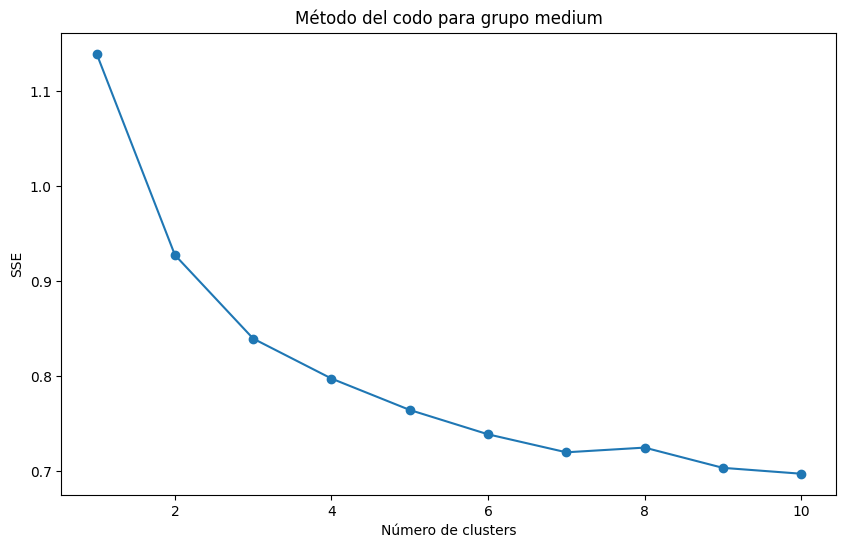

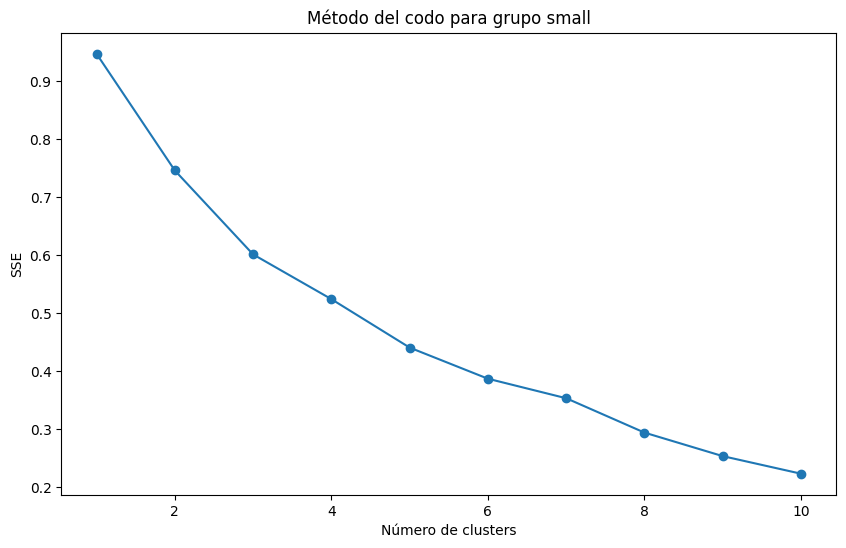

   product_id  customer_id  cluster  group
0       20001        10001        0  large
1       20001        10002        1  large
2       20001        10003        0  large
3       20001        10004        0  large
4       20001        10005        0  large


In [12]:

# Aplicar la función de clustering a cada grupo de clientes
groups = dataset['group'].unique()
all_clusters = []

for group in groups:
    clusters = cluster_customers_group(dataset, group)
    if not clusters.empty:  # Solo agregar clusters no vacíos
        clusters['group'] = group
        all_clusters.append(clusters)

# Combinar todos los clusters en un solo DataFrame
if all_clusters:
    final_clusters = pd.concat(all_clusters, ignore_index=True)
    print(final_clusters.head())
else:
    print("No se generaron clusters válidos.")

 

In [13]:
final_clusters.to_csv("C:/Users/vgarciario/desktop/UA MASTER/labo3/final_clusters.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, Activation
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping

# Supongamos que ya tienes los DataFrames 'productos_predecir' y 'sell_in'
# dataset = pd.merge(productos_predecir, sell_in, on='product_id', how='inner')
# Aquí, sustituye 'productos_predecir' y 'sell_in' con la lectura de los archivos correctos si es necesario

# Ejemplo de creación del dataset combinado
# productos_predecir = pd.read_csv('ruta/a/productos_predecir.csv')
# sell_in = pd.read_csv('ruta/a/sell_in.csv')
dataset = pd.merge(productos_predecir, sell_in, on='product_id', how='inner')
sell_in_completo = dataset.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()

# Convertir 'periodo' a datetime y establecer como índice
sell_in_completo['periodo'] = pd.to_datetime(sell_in_completo['periodo'].astype(str) + '01', format='%Y%m%d')
sell_in_completo.set_index("periodo", inplace=True)

# Verificar si 'periodo' y 'product_id' existen en el DataFrame
if 'periodo' not in sell_in_completo.index.names or 'product_id' not in sell_in_completo.columns:
    raise KeyError("Las columnas 'periodo' y/o 'product_id' no están presentes en el DataFrame 'sell_in_completo'.")

# Preparar datos para clustering usando únicamente la característica 'tn'
sell_in_completo = sell_in_completo.sort_values(by='periodo')

# Crear un DataFrame pivotado con NaNs para valores faltantes
tn_data = sell_in_completo.pivot_table(index='periodo', columns='product_id', values='tn')

# Aplicar promedio móvil para completar los valores faltantes por producto
tn_data_filled = tn_data.fillna(tn_data.rolling(3, min_periods=1).mean())  # Ventana de promedio móvil de tamaño 3

# Normalizar los datos
scaler = MinMaxScaler()
tn_data_normalizada = scaler.fit_transform(tn_data_filled)

# Transponer los datos para que estén en el formato (n_samples, n_timestamps)
tn_data_normalizada = tn_data_normalizada.T

# Aplicar TimeSeriesKMeans con DTW para clustering
num_clusters = 5  # Número de clusters
model_dtw = TimeSeriesKMeans(n_clusters=num_clusters, metric="dtw", random_state=0)
cluster_labels = model_dtw.fit_predict(tn_data_normalizada)

# Asignar cada producto a su cluster
product_clusters = pd.DataFrame({'product_id': tn_data.columns, 'cluster': cluster_labels})

# Unir resultados al dataset original
sell_in_completo = sell_in_completo.reset_index().merge(product_clusters, on='product_id').set_index('periodo')

# Lista para acumular las filas de resultados
resultados_por_producto = []

# Elegir un número de pasos de tiempo
n_steps = 12  # Ventana de tiempo de 12 meses
n_features = 1  # Cambia esto si tienes más características

# Función para crear secuencias de tiempo
def crear_secuencias(datos, n_steps, step_ahead=1):
    X, y = [], []
    for i in range(len(datos)):
        end_ix = i + n_steps
        out_end_ix = end_ix + step_ahead - 1
        if out_end_ix > len(datos) - 1:
            break
        seq_x, seq_y = datos[i:end_ix], datos[out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Definir la función para construir el modelo
def build_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(units=256, return_sequences=True), input_shape=(n_steps, n_features)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=128)))
    model.add(Dropout(0.3))
    model.add(Dense(64))
    model.add(Activation('tanh'))
    model.add(Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
    return model

# Inicializar EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

# Diccionario para realizar un seguimiento de los productos ya procesados
productos_procesados = {}

# Entrenar y predecir para cada cluster
for cluster in range(num_clusters):
    productos_cluster = sell_in_completo[sell_in_completo["cluster"] == cluster]["product_id"].unique()
    aux_combined = []
    
    for producto in productos_cluster:
        aux = sell_in_completo[sell_in_completo["product_id"] == producto].drop(columns=["product_id", "cluster"]).values
        
        # Asegurar que aux tenga al menos n_steps filas
        if aux.shape[0] < n_steps:
            aux = np.pad(aux, ((n_steps - aux.shape[0], 0), (0, 0)), 'constant')
        
        aux_normalizado = scaler.fit_transform(aux)
        aux_combined.append(aux_normalizado)

    # Concatenar las secuencias normalizadas
    aux_combined = np.concatenate(aux_combined, axis=0)
    X, y = crear_secuencias(aux_combined, n_steps, step_ahead=2)
    X = X.reshape((X.shape[0], X.shape[1], n_features))

    # Construir el modelo
    model = build_model()

    # Entrenar el modelo con todos los datos del cluster
    model.fit(X, y, epochs=200, batch_size=32, callbacks=[early_stopping], verbose=0)

    # Realizar predicciones individuales para cada producto del cluster
    for producto in productos_cluster:
        if producto not in productos_procesados:
            try:
                aux = sell_in_completo[sell_in_completo["product_id"] == producto].drop(columns=["product_id", "cluster"]).values
                
                # Asegurar que aux tenga al menos n_steps filas
                if aux.shape[0] < n_steps:
                    aux = np.pad(aux, ((n_steps - aux.shape[0], 0), (0, 0)), 'constant')
                    
                aux_normalizado = scaler.fit_transform(aux)
                ultima_secuencia = aux_normalizado[-n_steps:].reshape((1, n_steps, n_features))
                prediccion_normalizada = model.predict(ultima_secuencia)
                prediccion = scaler.inverse_transform(prediccion_normalizada)
                resultados_por_producto.append({'product_id': producto, 'prediccion_1': prediccion[0][0]})
                productos_procesados[producto] = True  # Marcar producto como procesado
            except Exception as e:
                print(f"Error al procesar el producto {producto}: {str(e)}")
                resultados_por_producto.append({'product_id': producto, 'prediccion_1': 0})
                productos_procesados[producto] = True  # Marcar producto como procesado

# Convertir la lista de resultados en un DataFrame
predicciones_por_producto = pd.DataFrame(resultados_por_producto)

# Mostrar el DataFrame con las predicciones por producto
print(predicciones_por_producto)

# Guardar el DataFrame con las predicciones por producto en un archivo CSV
predicciones_por_producto.to_csv("C:/Users/vgarciario/desktop/UA MASTER/labo3/lstmclusdtw2.csv", index=False)


c:\Users\vgARCIARIO\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

ValueError: need at least one array to concatenate